# Curvas Características P-V e I-V de uma Célula Fotovoltaica

Este programa estima parâmetros de uma célula fotovoltaica real e traça suas curvas características P-V e I-V para diferentes variações de temperatura e irradiância solar. Antes de traçar as curvas características P-V e I-V, é necessário calcular todos os parâmetros que não são dados no datasheet de um painel solar fotovoltaico.

In [1]:
import numpy as np
import sympy as sy # Importa o sympy como sy para poder utilizar a exponencial sy.exp() 
from sympy import *
%matplotlib inline
import matplotlib.pyplot as plt

""" 
Referências
------------

[1] Aminde, N. O. (2013). Controle extremal via funções de monitoração e reali-mentação de saída (Dissertação de mestrado). 
    Universidade Federal do Rio de Janeiro, Rio de Janeiro, RJ, Brasil.
[3] Sera, D., Teodorescu, R., & Rodriguez, P. (2007, June). PV panel model based on datasheet values. 
    IEEE International Symposium on Industrial Electron-ics, Vigo, Spain. 
[4] Villalva, M. G., Gazoli, J. R., & Filho, E. R. (2009). Comprehensive approach to modeling and simulation of 
    photovoltaic arrays. IEEE Transactions on Po-wer Electronics, 24(4), 1198-1208.
"""

class ModeloUmDiodo(object):
    """ Classe que estima parâmetros de uma célula fotovoltaica real e traça suas curvas características P-V e V-I 
    para diferentes variações de temperatura [K] e irradiância solar [W/m²]."""
    constante_boltzmann = 1.38065e-23 # Constante de Boltzann
    carga_eletron = 1.602e-19 # Carga do elétron
    temperatura_referencia = 25 + 273 # Temperatura de referência em Kelvin [K]
    irradiacao_referencia = 1000 # Irradiação de referência [W/m²]
    gap_energia = 1.12 # Gap de energia do silício à 25°C
    NOCT = 49 # Temperatura em Graus Celcius [°C]
    
    def __init__(self,
                 corrente_curto_circuito,
                 tensao_circuito_aberto,
                 numero_celulas_serie = 1,
                 coeficiente_temperatura_corrente = 0.003, 
                 fator_idealidade_diodo = 1.2):
        
        self.corrente_curto_circuito = corrente_curto_circuito
        self.tensao_circuito_aberto = tensao_circuito_aberto
        self.numero_celulas_serie = numero_celulas_serie
        self.coeficiente_temperatura_corrente = coeficiente_temperatura_corrente
        self.fator_idealidade_diodo = fator_idealidade_diodo
    
    # Sequencia de métodos que irão retornar os parâmetros da célula fotovoltaica
    
    def get_Tc(self): # Temperatura da célula
        return self.Tc
    
    def get_Vt(self): # Potencial térmico
        return self.Vt
    
    def get_Io(self): # Corrente Io
        return self.Io
    
    def get_Is(self): # Fonte de corrente Is
        return self.Is
    
    def get_Ior(self): # Corrente de Saturação Reversa
        return self.Ior
    
    def get_Isat(self): # Corrente de Saturação
        return self.Isat

    def get_I_vec(self): # Vetor da corrente nominal da célula
        return self.I_vec
    
    def get_V_vec(self): # Vetor da tensão nominal da célula
        return self.V_vec
    
    def get_Ilamb_vec(self): # Vetor da corrente nominal da célula utilizando o lambdify
        return self.Ilamb_vec
    
    def get_Vlamb_vec(self): # Vetor da tensão nominal da célula utilizando o lambdify
        return self.Vlamb_vec
    
    def get_Ipot_vec(self): # Vetor da corrente nominal da célula (cálculo da potência)
        return self.Ipot_vec
    
    def get_Vpot_vec(self): # Vetor da tensão nominal da célula (cálculo da potência)
        return self.Vpot_vec
    
    def get_P_vec(self): # Vetor da potência nominal da célula
        return self.P_vec
    
    # Métodos que irão calcular os parâmetros da célula solar fotovoltaica. 
    
    def temperatura_celula(self, irradiancia_ambiente, temperatura_ambiente):
        # Baseada na equação (4) e depende do NOCT, irradiação e temperatura ambientes
        Tc = temperatura_ambiente+(irradiancia_ambiente*(self.NOCT - 20))/800
        self.Tc = Tc
    
    def potencial_termico(self):
        # Baseado na definição de potêncial térmico
        Vt = (self.constante_boltzmann*self.numero_celulas_serie*self.Tc)/self.carga_eletron
        self.Vt = Vt
    
    def corrente_inicial(self, irradiancia_ambiente):
        # Baseada na equação (3) e define o valor da corrente Io
        Io = (irradiancia_ambiente*self.corrente_curto_circuito)/self.irradiacao_referencia
        self.Io = Io
    
    def fonte_corrente(self):
        # Baseada na equação (2) e define o valor da fonte de corrente do circuito equivalente
        Is = self.Io + self.coeficiente_temperatura_corrente*(self.Tc - self.temperatura_referencia)
        self.Is = Is
    
    def corrente_saturacao_reversa(self):
        # Baseada na equação (7) e define a corrente de saturação reversa do diodo
        Ior = self.corrente_curto_circuito/(np.exp((self.carga_eletron*self.tensao_circuito_aberto)/
                (self.constante_boltzmann*self.fator_idealidade_diodo*self.Tc))-1)
        self.Ior = Ior
    
    def corrente_saturacao(self):
        # Baseada na equação (6) e define a corrente de saturação do diodo
        Isat = self.Ior*((self.Tc/self.temperatura_referencia)**3)*np.exp(((self.carga_eletron*self.gap_energia)/
                (self.constante_boltzmann*self.fator_idealidade_diodo))*
                (1/self.temperatura_referencia - 1/self.Tc))
        self.Isat = Isat
        
    # Sequência de funções que calcula a corrente, tensão e potência nominal da célula fotovoltaica.
    def corrente_nominal(self, irradiancia_ambiente, temperatura_ambiente):
        """Esta função retorna a corrente e tensão nominal da célula, inserindo o valor da irradiância ambiente
        [W/m²] e a temperatura ambiente [K]."""
        # Utiliza os métodos anteriores para calcular os parâmetros da célula Fotovoltaica
        self.temperatura_celula(irradiancia_ambiente, temperatura_ambiente) 
        self.potencial_termico() 
        self.corrente_inicial(irradiancia_ambiente)
        self.fonte_corrente()
        self.corrente_saturacao_reversa()
        self.corrente_saturacao()
        
        # Calcula a corrente nominal da célula Fotovoltaica através dos parâmetros encontrados
        V = Symbol ('V') # Determina V como um símbolo
        V_vec = np.arange(0, self.tensao_circuito_aberto, 0.001) # Cria um vetor de tensão de acordo com Voc inserido
        I_vec = np.array([N(self.Is - self.Isat*(sy.exp(V/ # Cria o vetor de corrente nominal utilizando o vetor V_vec
                (self.fator_idealidade_diodo*self.Vt))-1).subs(V, xx)) for xx in V_vec]) 
        self.I_vec = I_vec
        self.V_vec = V_vec
        
    def corrente_nominal_lamb(self, irradiancia_ambiente, temperatura_ambiente):
        """Esta função retorna a corrente e tensão nominal da célula, inserindo o valor da irradiância ambiente
        [W/m²] e a temperatura ambiente [K] utilizando o lambdify do Sympy."""
        # A função Lambdify transforma expressões do Sympy em funções "lambda"
        # que podem ser utilizadas para calcular valores numéricos rapidamente
        
        # Utiliza os métodos anteriores para calcular os parâmetros da célula Fotovoltaica
        self.temperatura_celula(irradiancia_ambiente, temperatura_ambiente)
        self.potencial_termico()
        self.corrente_inicial(irradiancia_ambiente)
        self.fonte_corrente()
        self.corrente_saturacao_reversa()
        self.corrente_saturacao()
        
        # Calcula a corrente nominal da célula Fotovoltaica através dos parâmetros encontrados
        Vlamb = Symbol ('Vlamb') # Determina Vlamb como um símbolo
        Vlamb_vec = np.arange(0, self.tensao_circuito_aberto, 0.001) # Cria um vetor de tensão de acordo com Voc inserido
        f = lambdify([Vlamb], self.Is - self.Isat*(sy.exp(Vlamb/(self.fator_idealidade_diodo*self.Vt))-1), 'numpy')
        Ilamb_vec = f(Vlamb_vec) # Utiliza-se o lambdify do Sympy para calcular o vetor de corrente
        self.Vlamb_vec = Vlamb_vec
        self.Ilamb_vec = Ilamb_vec
                     
    def potencia_nominal(self, irradiancia_ambiente, temperatura_ambiente):
        """Esta função retorna a potência e tensão nominal da célula, inserindo o valor da irradiância ambiente
        [W/m²] e a temperatura ambiente [K]."""
        # Utiliza os métodos anteriores para calcular os parâmetros da célula Fotovoltaica
        self.temperatura_celula(irradiancia_ambiente, temperatura_ambiente)
        self.potencial_termico()
        self.corrente_inicial(irradiancia_ambiente)
        self.fonte_corrente()
        self.corrente_saturacao_reversa()
        self.corrente_saturacao()
        
        # Calcula a potência nominal da célula Fotovoltaica através dos parâmetros encontrados
        Vpot = Symbol ('Vpot') # Determina Vpot como um símbolo
        Vpot_vec = np.arange(0, self.tensao_circuito_aberto, 0.001) # Cria um vetor de tensão de acordo com Voc inserido
        Ipot_vec = np.array([N(self.Is - self.Isat*(sy.exp(Vpot/ # Cria o vetor de corrente utilizando o vetor Vpot_vec
                (self.fator_idealidade_diodo*self.Vt))-1).subs(Vpot, xx)) for xx in Vpot_vec])
        P_vec = Vpot_vec*Ipot_vec # Defeni-se o vetor de potência da célula 
        self.P_vec = P_vec
        self.Ipot_vec = Ipot_vec
        self.Vpot_vec = Vpot_vec
        
    def plota_grafico_corrente(self):
        """Esta função retorna do gráfico da curva característica I-V"""
        i_max = self.I_vec.max() # Calcula os valores máximos dos vetores de corrente e tensão
        v_max = self.V_vec.max()
        
        plt.figure(figsize=(8, 4), dpi=80) # Define o tamanho da figura em polegadas e dpi = pontos por polegada
        plt.plot(self.V_vec, self.I_vec, color="navy", linewidth=2.5, linestyle="-", label = "I-V")
        plt.legend(loc='best') # Insere a legenda no "melhor" local da figura
        plt.xlim(0, float(v_max)*0.9) # Define os limites do eixo x e y
        plt.ylim(0, float(i_max)*1.1)
        plt.xlabel('Tensão [V]') # Define-se o titulo dos eixos x e y
        plt.ylabel('Corrente [I]')
        plt.title('Curva Característica I-V') # Define-se o titulo do gráfico
        plt.grid(True) # Insere grade no gráfico
        
    def plota_grafico_potencia(self):
        """Esta função retorna do gráfico da curva característica P-V"""
        p_max = self.P_vec.max() # Calcula os valores máximos dos vetores de potência e tensão
        vpot_max = self.Vpot_vec.max()
        
        plt.figure(figsize=(8, 4), dpi=80) # Define o tamanho da figura em polegadas e dpi = pontos por polegada
        plt.plot(self.Vpot_vec, self.P_vec, color="tomato", linewidth=2.5, linestyle="-", label = "P-V")
        plt.legend(loc='best') # Insere a legenda no "melhor" local da figura
        plt.xlim(0, float(vpot_max)*0.9) # Define os limites do eixo x e y
        plt.ylim(0, float(p_max)*1.1)
        plt.xlabel('Tensão [V]') # Define-se o titulo dos eixos x e y
        plt.ylabel('Potência [W]')
        plt.title('Curva Característica P-V') # Define-se o titulo do gráfico
        plt.grid(True) # Insere grade no gráfico            
                     
    def plota_grafico_corrente_lamb(self):
        """Esta função retorna do gráfico da curva característica I-V utilizando o lambdify do Sympy"""
        ilamb_max = self.Ilamb_vec.max() # Calcula os valores máximos dos vetores de corrente e tensão
        vlamb_max = self.Vlamb_vec.max()
        
        plt.figure(figsize=(8, 4), dpi=80) # Define o tamanho da figura em polegadas e dpi = pontos por polegada
        plt.plot(self.Vlamb_vec, self.Ilamb_vec, color="darkgreen", linewidth=2.5, linestyle="-", label = "I-V")
        plt.legend(loc='best') # Insere a legenda no "melhor" local da figura
        plt.xlim(0, float(vlamb_max)*0.9) # Define os limites do eixo x e y
        plt.ylim(0, float(ilamb_max)*1.1)
        plt.xlabel('Tensão [V]') # Define-se o titulo dos eixos x e y
        plt.ylabel('Corrente [I]')
        plt.title('Curva Característica I-V Utilizando o Lambdify') # Define-se o titulo do gráfico
        plt.grid(True) # Insere grade no gráfico

819 ms ± 78.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


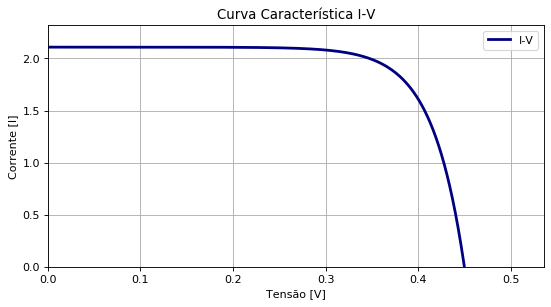

In [2]:
# EXEMPLOS DE USO - Curva Característica I-V para Isc= 2 [A] e Voc = 0,596 [V]
# Irradiação Solar de Ga = 1000 W/m² e Temperatura Ambiente Ta = 298 Kelvin
a = ModeloUmDiodo(2, 0.596)
%timeit a.corrente_nominal(1000, 298)
a.plota_grafico_corrente()

923 ms ± 62.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


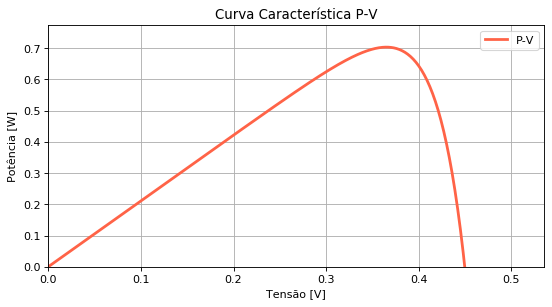

In [3]:
# EXEMPLOS DE USO - Curva Característica P-V para Isc= 2 [A] e Voc = 0,596 [V]
# Irradiação Solar de Ga = 1000 W/m² e Temperatura Ambiente Ta = 298 Kelvin
b = ModeloUmDiodo(2, 0.596)
%timeit b.potencia_nominal(1000,298)
b.plota_grafico_potencia()

1.47 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


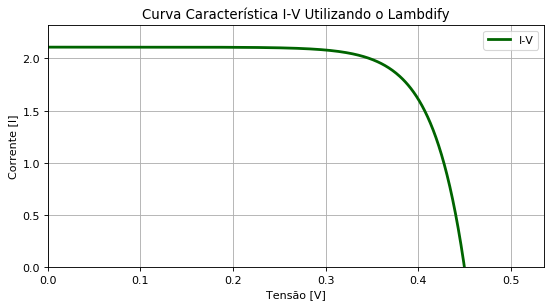

In [4]:
# EXEMPLOS DE USO - Curva Característica P-V para Isc= 2 [A] e Voc = 0,596 [V]
# Irradiação Solar de Ga = 1000 W/m² e Temperatura Ambiente Ta = 298 Kelvin
# Utilizando o lambdify do Sympy
c = ModeloUmDiodo(2, 0.596)
%timeit c.corrente_nominal_lamb(1000,298)
c.plota_grafico_corrente_lamb()

713 ms ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


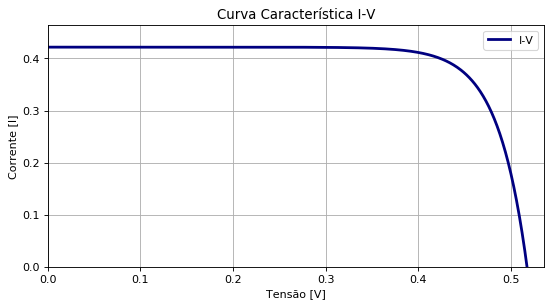

In [5]:
# EXEMPLOS DE USO - Curva Característica I-V para Isc= 2 [A] e Voc = 0,596 [V]
# Irradiação Solar de Ga = 200 W/m² e Temperatura Ambiente Ta = 298 Kelvin
d = ModeloUmDiodo(2, 0.596)
%timeit d.corrente_nominal(200, 298)
d.plota_grafico_corrente()

906 ms ± 38.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


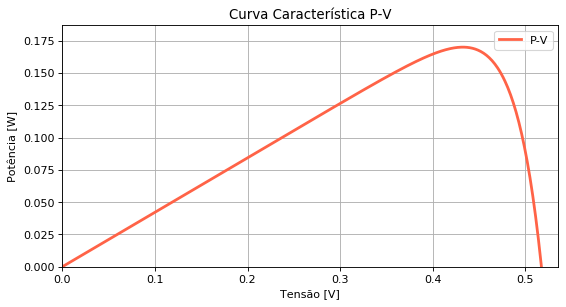

In [6]:
# EXEMPLOS DE USO - Curva Característica P-V para Isc= 2 [A] e Voc = 0,596 [V]
# Irradiação Solar de Ga = 200 W/m² e Temperatura Ambiente Ta = 298 Kelvin
e = ModeloUmDiodo(2, 0.596)
%timeit e.potencia_nominal(200,298)
e.plota_grafico_potencia()

1.39 ms ± 55.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


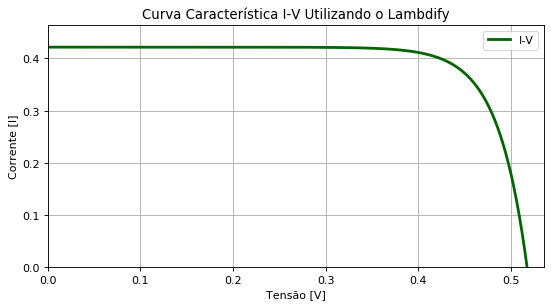

In [7]:
# EXEMPLOS DE USO - Curva Característica P-V para Isc= 2 [A] e Voc = 0,596 [V]
# Irradiação Solar de Ga = 200 W/m² e Temperatura Ambiente Ta = 298 Kelvin
# Utilizando o lambdify do Sympy
f = ModeloUmDiodo(2, 0.596)
%timeit f.corrente_nominal_lamb(200,298)
f.plota_grafico_corrente_lamb()

686 ms ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


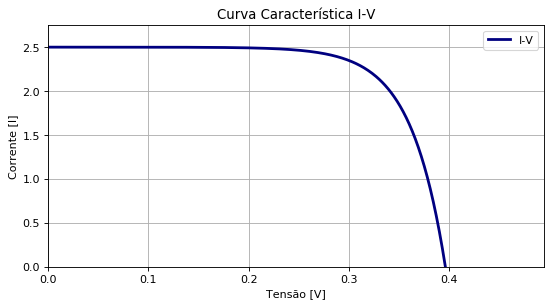

In [8]:
# EXEMPLOS DE USO LIVRE - Curva Característica I-V para Isc e Voc desejados
# Irradiação Solar Ga [W/m²] e Temperatura Ambiente Ta [K]
# Seguir indicações do item 3.1. Limitações Físicas da Célula Fotovoltaica e Ambientais
g = ModeloUmDiodo(4, 0.55)
%timeit g.corrente_nominal(600, 310)
g.plota_grafico_corrente()

832 ms ± 40.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


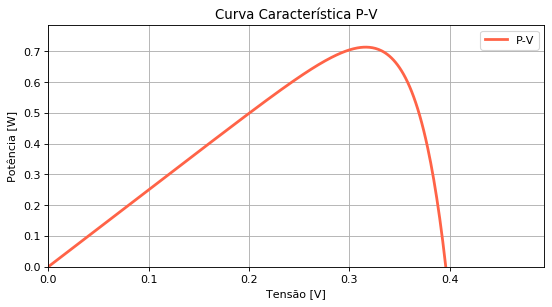

In [9]:
# EXEMPLOS DE USO LIVRE - Curva Característica P-V para Isc e Voc desejados
# Irradiação Solar Ga [W/m²] e Temperatura Ambiente Ta [K]
# Seguir indicações do item 3.1. Limitações Físicas da Célula Fotovoltaica e Ambientais
h = ModeloUmDiodo(4, 0.55)
%timeit h.potencia_nominal(600,310)
h.plota_grafico_potencia()

1.64 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


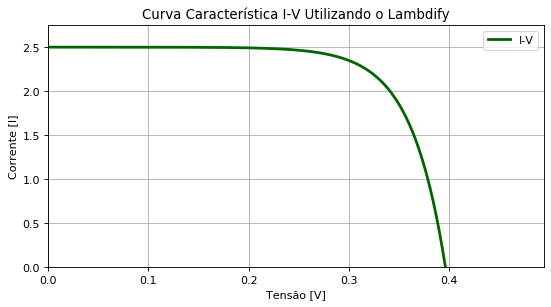

In [10]:
# EXEMPLOS DE USO LIVRE - Curva Característica P-V para Isc e Voc desejados
# Irradiação Solar Ga [W/m²] e Temperatura Ambiente Ta [K]
# Seguir indicações do item 3.1. Limitações Físicas da Célula Fotovoltaica e Ambientais
# Utilizando o lambdify do Sympy
i = ModeloUmDiodo(4, 0.55)
%timeit i.corrente_nominal_lamb(600,310)
i.plota_grafico_corrente_lamb()